In [1]:
%cd /Users/lucas/repositories/degen_discovery/simple_problems/remote_runs/

/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs


/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
pwd

'/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs'

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from pyoperon.sklearn import SymbolicRegressor
import multiprocessing
import csv
from sklearn.metrics import r2_score
import string
import sys
import sympy
import scipy
import esr.generation.generator

import jax
import jax.numpy as jnp

from tqdm import tqdm as tq


In [4]:
# from postprocessing_utils import load_and_process_data, process_ensemble_rotation

# Import preprocessing (rotations, data loading)
from preprocessing_utils import (
    load_and_process_data,
    process_ensemble_rotation,
    flatten_with_numerical_jacobian,
    batch_flatten_fisher,
    rotate_coords,
    load_and_process_data,
    weighted_std
)

# Import postprocessing (SR optimization)
from postprocessing_utils import (
    lossfn_jac_jax,
    get_component,
    get_pruned_expressions,
    get_pruned_expressions_final,
    check_flattening,
    make_check_flattening_fn,
)

# Create loss function
# _lossfn = lambda a: lossfn_jac_jax(
#     a, all_pars, all_fns, all_linear_pars, all_linear_inds,
#     X=X, Fs=Fs, n_params=n_params, delta=0.2, alpha=1.5
# )

# Option 1: Load and process in one call
data = load_and_process_data(
    datapath="",
    filename="/Users/lucas/repositories/degen_discovery/simple_problems/flattened_coords_little_sigma.npz",
    num_samps=4000,
    process_ensemble=True,  # <-- enables full processing
    n_d=1.0,
    verbose=True,
    y_reference_index=None,
)

# Access results directly:
y = data['y']           # Weighted average outputs (masked)
y_std = data['y_std']   # Weighted std (masked)
dy = data['dy']         # Weighted average Jacobian (masked)
dy_sr = data['dy_sr']   # Weighted average rotated Jacobian
Fs = data['Fs']         # Weighted average Fisher
X = data['X']           # Parameters (masked)

n_params = 2

# Option 2: Two-step process (more control)
# data = load_and_process_data(datapath="./", filename="fake_cmb_flatten_03_09_sum.npz", process_ensemble=False)
# result = process_ensemble_rotation(
#     datafile=data['datafile'],
#     randidx=data['randidx'],
#     Favg=data['Favg'],
#     best_model_idx=data['best_model_idx'],
#     n_d=1.0
# )

best model 15
Network 0: y.min() = -64.916046, weight = 1.5
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 1: y.min() = -66.413498, weight = 1.7
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 2: y.min() = -73.030022, weight = 2.2
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 3: y.min() = -76.787506, weight = 2.3
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 4: y.min() = -71.180450, weight = 1.2
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 5: y.min() = -71.981781, weight = 2.1
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 6: y.min() = -73.748482, weight = 2.2
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 7: y.min() = -61.438313, weight = 1.7
thetastar [-0.03483295  3.6325028 ]
  Shapes: y=(4000, 2), X=(4000, 2)
Network 8: y.min() = -78.564796, weight = 2.3
thet

In [5]:
pwd

'/Users/lucas/repositories/degen_discovery/simple_problems/remote_runs'

In [6]:
data['dys'].shape

In [7]:
data['eta_ensemble'].shape

In [8]:
alpha = np.random.rand() * 2 * np.pi
R = np.array([[np.cos(alpha), -np.sin(alpha), 0],
                [np.sin(alpha), np.cos(alpha), 0],
                [0, 0, 1]])
# t = np.random.randn(3) * 10

ytest = data['eta_ensemble'][12]




# ytest = ytest[:, _ind]

ytest_rot, *_ = rotate_coords(ytest, X, Fs, data['dys'][12], y_reference=data['eta_ensemble'][0])

# _ind = np.argsort(ytest_rot.var(0))[::-1]
# ytest_rot = ytest_rot[:, _ind]


# now rotate by random vector
R = np.array([[np.cos(alpha), -np.sin(alpha),],
                [np.sin(alpha), np.cos(alpha),]])


from scipy.stats import ortho_group  # Requires version 0.18 of scipy

R = ortho_group.rvs(dim=n_params)

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Fs, data["dys"][12],  y_reference= data['eta_ensemble'][0])

# change order of indexes
# _ind = np.argsort(ytest_p_rot.var(0))[::-1]
# ytest_p_rot = ytest_p_rot[:, _ind]






thetastar [-0.03483295  3.6325028 ]
thetastar [-0.03483295  3.6325028 ]


In [9]:
ytest_p_rot.mean(0)

array([-1.32206232e-13, -6.76453338e-15])

thetastar [-0.03483295  3.6325028 ]
thetastar [-0.03483295  3.6325028 ]


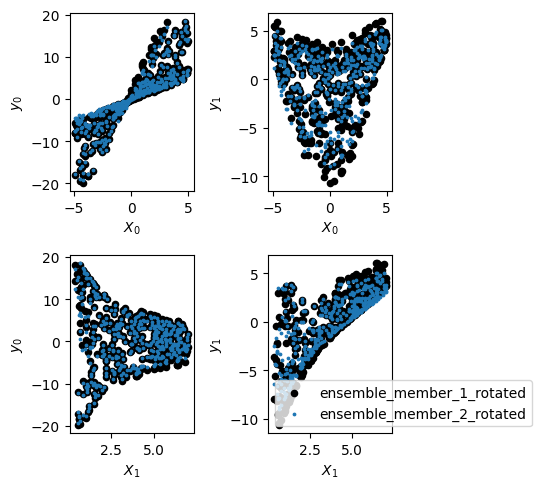

In [10]:
# repeat same test but for a different ensemble member (same perturbed orthogonal matrix)

ytest = data['eta_ensemble'][9]

ytest_rot, *_ = rotate_coords(ytest, X, Fs, data["dys"][0], y_reference= data['eta_ensemble'][2], use_var=False)

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p = data['eta_ensemble'][0]

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Fs, data["dys"][0],  y_reference= data['eta_ensemble'][2], use_var=False)




fig, axs = plt.subplots(2, 2, figsize=(5,5))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        # axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='ensemble_member_1', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_rot[::skip, j], label='ensemble_member_1_rotated', s=20, c='k')
        # axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='ensemble_member_2', s=3)
        axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='ensemble_member_2_rotated', s=3)


        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.legend()
plt.tight_layout()
plt.show()

thetastar [-0.03483295  3.6325028 ]
thetastar [-0.03483295  3.6325028 ]


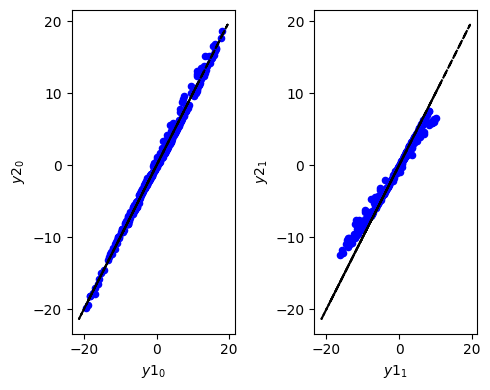

In [11]:
# repeat same test but for a different ensemble member (same perturbed orthogonal matrix)

ytest = data['eta_ensemble'][3]

ytest_rot, *_ = rotate_coords(ytest, X, Fs, data['dys'][0], y_reference= data['eta_ensemble'][0])

ytest_p = np.einsum("ij,bj->bi", R, ytest)

ytest_p = data['eta_ensemble'][6]

ytest_p_rot, *_ = rotate_coords(ytest_p, X, Fs, data['dys'][0],  y_reference= data['eta_ensemble'][0])

# ytest_p_rot = ytest_p

fig, axs = plt.subplots(1, 2, figsize=(5,4))

skip=10

for i in range(X.shape[-1]):

        
    # row, column
    # axs[i,j].scatter(X[::skip,i], ytest[::skip, j], label='ensemble_member_1', s=3)
    axs[i].scatter(ytest_rot[::skip,i], ytest_p_rot[::skip, i], label='ensemble_member_1_rotated', s=20, c='blue')
    axs[i].plot(ytest_rot, ytest_rot, c='k', ls='--')
    # axs[i,j].scatter(X[::skip,i], ytest_p[::skip, j], label='ensemble_member_2', s=3)
    # axs[i,j].scatter(X[::skip,i], ytest_p_rot[::skip, j], label='ensemble_member_2_rotated', s=3)


    axs[i].set_xlabel(r"$y1_%d$"%(i))
    axs[i].set_ylabel(r"$y2_%d$"%(i))

# plt.legend()
plt.tight_layout()
plt.show()

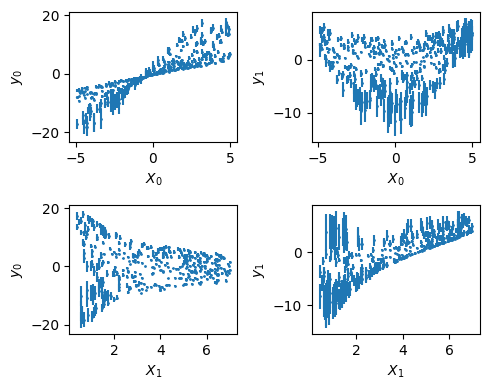

In [12]:
# create scatterplot to see how y responds to X

fig, axs = plt.subplots(2, 2, figsize=(5,4))

skip=10

for i in range(X.shape[-1]):
    for j in range(y.shape[-1]):
        
        # row, column
        axs[i,j].errorbar(X[::skip,i], y[::skip, j], yerr=y_std[::skip, j], label='', fmt='o', markersize=1)

        axs[i,j].set_xlabel(r"$X_%d$"%(i))
        axs[i,j].set_ylabel(r"$y_%d$"%(j))

plt.tight_layout()
plt.show()

In [13]:
y[0]

array([-8.510327, -7.912091], dtype=float32)

In [14]:
np.cov(y, rowvar=False).shape

Text(0, 0.5, '$y$')

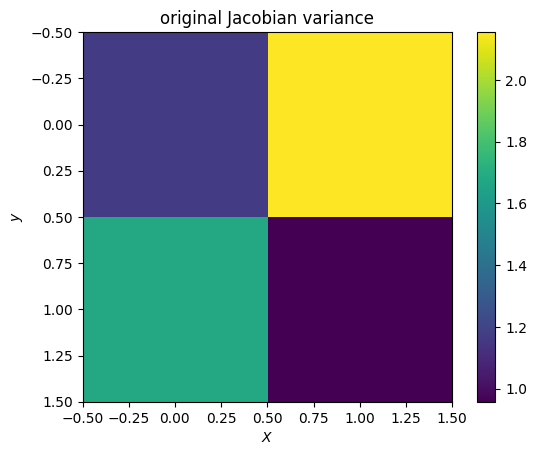

In [15]:
plt.imshow(dy.std(0))
plt.colorbar()
plt.title('original Jacobian variance')
plt.xlabel("$X$")
plt.ylabel("$y$")

Text(0, 0.5, '$y$')

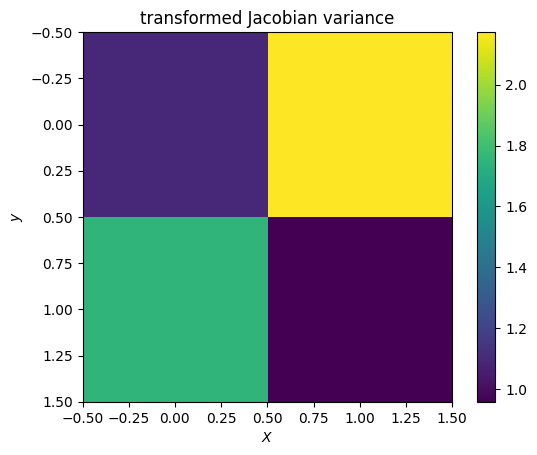

In [16]:
plt.imshow(dy_sr.std(0))
plt.colorbar()
plt.title('transformed Jacobian variance')
plt.xlabel("$X$")

plt.ylabel("$y$")

Text(0, 0.5, '$y$')

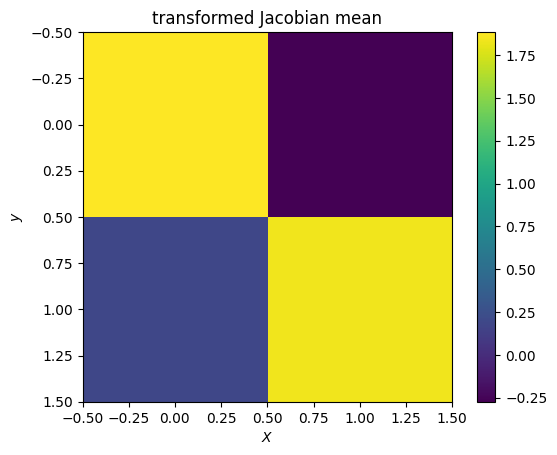

In [17]:
plt.imshow(dy_sr.mean(0))
plt.colorbar()
plt.title('transformed Jacobian mean')
plt.xlabel("$X$")
plt.ylabel("$y$")

In [18]:
np.dot(dy_sr[45, 0, :], dy_sr[45, 1, :])

0.08059462

Text(0, 0.5, '$y$')

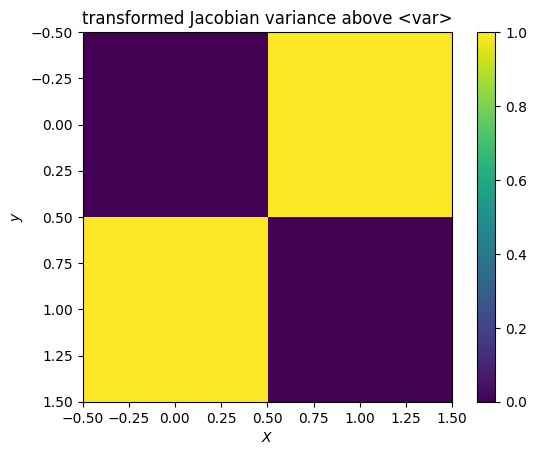

In [19]:
plt.imshow(dy_sr.var(0) > (dy_sr.var(0).mean()))
plt.colorbar()
plt.title('transformed Jacobian variance above <var>')
plt.xlabel("$X$")
plt.ylabel("$y$")

Text(0, 0.5, '$y$')

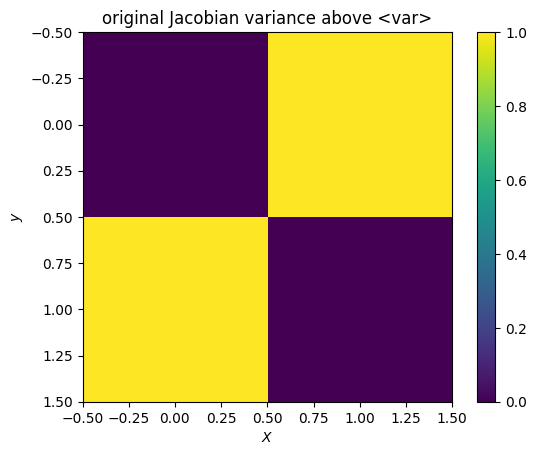

In [20]:
plt.imshow(dy.std(0) > (dy.std(0).mean()))
plt.colorbar()
plt.title('original Jacobian variance above <var>')
plt.xlabel("$X$")
plt.ylabel("$y$")

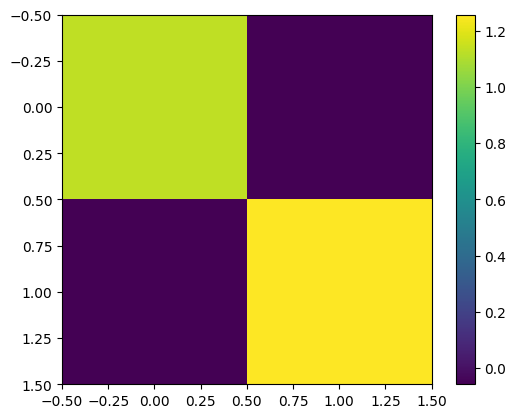

In [21]:
# foo = dy_sr / np.sqrt(0.5)
plt.imshow(jax.vmap(flatten_with_numerical_jacobian)(dy, Fs).mean(0))
plt.colorbar()

Text(0, 0.5, '$\\langle\\eta_{0,j}\\rangle$')

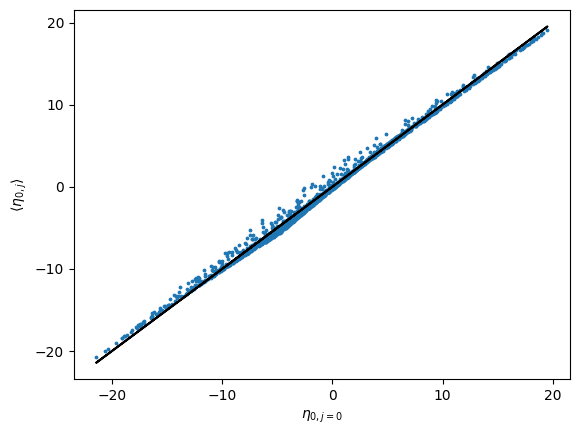

In [22]:
plt.scatter(data['ys'][0, ::2, 0], np.average(data['ys'][1:, ::2, 0], axis=0, \
                            weights=(data['ensemble_weights'][1:])), s=3) 

plt.plot(data['ys'][0, ::2, 0],data['ys'][0, ::2, 0], c='k')
plt.xlabel(r"$\eta_{0,j=0}$")
plt.ylabel(r"$\langle\eta_{0,j}\rangle$")

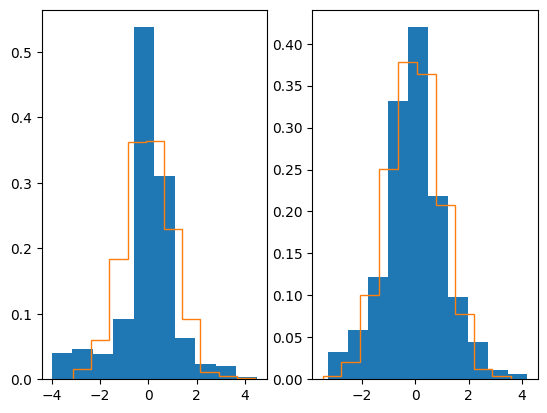

In [23]:
fig,axs = plt.subplots(1,2)
axs = axs.flatten()

for i,ax in enumerate(axs):
    ax.hist(((data['ys'] - y) / y_std)[:, :, i].flatten(), density=True)
    ax.hist(np.random.normal(size=(2000,)).flatten(), histtype='step', density=True)

In [24]:
(np.sqrt(np.linalg.det(Fs).mean()))

13.563198

In [25]:
# Some parameters for operon
parent_dir = './example_1/'


allowed_symbols = 'add,mul,pow,constant,variable,exp,logabs' # logabs exp sqrt square
epsilon = 1e-5 # 1e-5
max_length = 25 # 25
max_depth = 10
time_limit = 60 * 2 # s
objectives=['r2', 'length'] #['rmse', 'length']#['rmse', 'length']
max_evaluations=1e8
generations=1e8



In [26]:
# X -= X.mean(0) # try zero-centering


components_to_fit = [0, 1]


if not os.path.isdir(parent_dir):
    os.mkdir(parent_dir)

n_components = len(components_to_fit)

halfx = X.shape[0] // 2


for i in range(n_components):

    out_dir = parent_dir + "component_%d"%(i+1)
    
    if not os.path.isdir(out_dir):
        os.mkdir(out_dir)


    Xfit = X[:halfx]
    yfit = y[:halfx, i]
    y_std_fit = y_std[:halfx]
        
    reg = SymbolicRegressor(
                allowed_symbols=allowed_symbols,
                offspring_generator='basic',
                optimizer_iterations=10, # 1000
                max_length=max_length,
                max_depth=max_depth,
                initialization_method='btc',
                n_threads=multiprocessing.cpu_count(),
                objectives = objectives,
                epsilon = epsilon,
                random_state=2345,
                reinserter='keep-best',
                max_evaluations=int(max_evaluations),
                symbolic_mode=False,
                #max_time=int(time_limit),
                time_limit=int(time_limit),
                generations=int(generations),
                add_model_scale_term           = True,
                add_model_intercept_term       = True,
               #uncertainty=y_std_fit[:, i],
    )

    print("X train shape", Xfit.shape, "y train shape", yfit.shape)

    print('Fitting')
    reg.fit(Xfit, yfit) #, sample_weight = 1. / y_std_fit[:, i]**2.)
    print('Done')
    print(reg.get_model_string(reg.model_, 2))
    print(reg.stats_)


    # Save Pareto front
    with open(f'{out_dir}/pareto.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        
        print(f'Outputting {len(reg.pareto_front_)} individuals on Pareto front')
        
        for i in range(len(reg.pareto_front_)):
            writer.writerow([reg.pareto_front_[i]['tree'].Length,
                            reg.pareto_front_[i]['mean_squared_error'],
                            reg.pareto_front_[i]['model'],
                            ])
            
    # Save population
    print(f'Outputting {len(reg.individuals_)} individuals in population')
    with open(f'{out_dir}/final_population.csv', 'w') as f:
        
        writer = csv.writer(f, delimiter=';')
        writer.writerow(['length',
                        'mse',
                        'model',
        ])
        for ind in reg.individuals_[:reg.population_size]:
            tree = ind.Genotype
            
            # Get name but block printing to sys.stderr
            sys.stderr = open(os.devnull, 'w')
            s = reg.get_model_string(ind.Genotype, 10)
            sys.stderr = sys.__stderr__
            
            y_pred = reg.evaluate_model(tree, Xfit)
            mse = np.mean((yfit - y_pred)**2)
            
            writer.writerow([tree.Length,
                            mse,
                            s
                            ])

X train shape (2000, 2) y train shape (2000,)
Fitting
Done
((-0.49) + (1.01 * ((0.78 * X1) + (((-21.32) + ((exp(exp(((-0.19) * X1))) ^ (0.25 * X1)) * 25.15)) * exp(((-0.45) * X2))))))
{'model_length': 14, 'model_complexity': 22, 'generations': 747, 'evaluation_count': 0, 'residual_evaluations': 5611010, 'jacobian_evaluations': 3890663, 'random_state': 2345}
Outputting 23 individuals on Pareto front
Outputting 2000 individuals in population
X train shape (2000, 2) y train shape (2000,)
Fitting
Done
(0.01 + (1.00 * (((exp(((-0.40) * X2)) + (0.02 * X2)) * (((-16.80) + (1.48 * X1)) * ((exp(((-0.15) * X1)) + (0.42 * X1)) * (exp(((-0.03) * X2)) + ((-0.24) * X1))))) + exp((0.27 * X2)))))
{'model_length': 21, 'model_complexity': 37, 'generations': 1097, 'evaluation_count': 0, 'residual_evaluations': 8334311, 'jacobian_evaluations': 5803525, 'random_state': 2345}
Outputting 22 individuals on Pareto front
Outputting 2000 individuals in population


9it [00:12,  1.41s/it]
8it [00:01,  5.99it/s]
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:6633: UserWarning: Explicitly requested dtype float64 requested in eye is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  output = _eye(N, M=M, k=k, dtype=dtype)
/usr/local/Caskroom/miniconda/base/envs/pyoperon/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:118: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  return lax_numpy.astype(self, dtype, copy=copy, device=device)
2it [00:01,  1.51

In [29]:
halfx = X.shape[0] // 2
print(halfx)
# switch to validation set
X = X[halfx:]
y = y[halfx:]
y_std = y_std[halfx:]
dy = dy[halfx:]
dy_sr = dy_sr[halfx:]

Fs = Fs[halfx:]


2000


In [30]:
Fs.shape, X.shape, y.shape, y_std.shape, dy_sr.shape

In [31]:
import jax
jax.config.update("jax_debug_nans", False)

In [32]:
import sympy

n_params = 2

@jax.jit
def norm(A):
    return jnp.sqrt(jnp.einsum('ij,ij->', A, A))


def split_by_punctuation(s):
    """
    Convert a string into a list, where the string is split by punctuation,
    excluding underscores or full stops.
    
    For example, the string 'he_ll*o.w0%rl^d' becomes
    ['he_ll', '*', 'o.w0', '%', 'rl', '^', 'd']
    
    Args:
        :s (str): The string to split up
        
    Returns
        :split_str (list[str]): The string split by punctuation
    
    """
    pun = string.punctuation.replace('_', '') # allow underscores in variable names
    pun = string.punctuation.replace('.', '') # allow full stops
    pun = pun + ' '
    where_pun = [i for i in range(len(s)) if s[i] in pun]
    if len(where_pun) > 0:
        split_str = [s[:where_pun[0]]]
        for i in range(len(where_pun)-1):
            split_str += [s[where_pun[i]]]
            split_str += [s[where_pun[i]+1:where_pun[i+1]]]
        split_str += [s[where_pun[-1]]]
        if where_pun[-1] != len(s) - 1:
            split_str += [s[where_pun[-1]+1:]]
    else:
        split_str = [s]
        
    # Remove spaces
    split_str = [s.strip() for s in split_str if len(s) > 0 and (not s.isspace())]
    
    return split_str

def is_float(s):
    """
    Function to determine whether a string has a numeric value
    
    Args:
        :s (str): The string of interest
        
    Returns:
        :bool: True if s has a numeric value, False otherwise
        
    """
    try:
        float(eval(s))
        return True
    except:
        return False

def replace_floats(s):
    """
    Replace the floats in a string by parameters named b0, b1, ...
    where each float (even if they have the same value) is assigned a
    different b.
    
    Args:
        :s (str): The string to consider
        
    Returns:
        :replaced (str): The same string, but with floats replaced by parameter names
        :values (list[float]): The values of the parameters in order [b0, b1, ...]
        
    """
    split_str = split_by_punctuation(s)
    values = []
    
    # Initial pass at replacing floats
    for i in range(len(split_str)):
        if is_float(split_str[i]) and "." in split_str[i]:
            values.append(float(split_str[i]))
            split_str[i] = f'b{len(values)-1}'
        elif len(split_str[i]) > 1 and split_str[i][-1] == 'e' and is_float(split_str[i][:-1]):
            if split_str[i+1] in ['+', '-']:
                values.append(float(''.join(split_str[i:i+3])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
                split_str[i+2] = ''
            else:
                assert split_str[i+1].is_digit()
                values.append(float(''.join(split_str[i:i+2])))
                split_str[i] = f'b{len(values)-1}'
                split_str[i+1] = ''
    
    # Now check for negative parameters
    for i in range(len(values)):
        idx = split_str.index(f'b{i}')
        if (idx == 1) and (split_str[0] == '-'):
            split_str[0] = ''
            values[i] *= -1
        elif (split_str[idx-1] == '-') and (split_str[idx-2] in ['+','-','*','/','(','^']):
            values[i] *= -1
            split_str[idx-1] = ''

    # Rejoin string
    replaced = ''.join(split_str)

    return replaced, values


def compute_DL(eq, idx):

    component_idx = idx #components_to_fit[idx] # slot in the component that we're fitting in terms of where it falls in y vector

    basis_functions = [["X", "b"],  # type0
            ["square", "exp", "inv", "sqrt", "log", "cos", "logAbs"],  # type1
            ["+", "*", "-", "/", "^"]]  # type2

    a, b = sympy.symbols('a b', real=True)
    sympy.init_printing(use_unicode=True)
    inv = sympy.Lambda(a, 1/a)
    square = sympy.Lambda(a, a*a)
    cube = sympy.Lambda(a, a*a*a)
    sqrt = sympy.Lambda(a, sympy.sqrt(a))
    log = sympy.Lambda(a, sympy.log(a))
    logAbs = sympy.Lambda(a, sympy.log(sympy.Abs(a)))
    power = sympy.Lambda((a,b), sympy.Pow(a, b))

    sympy_locs = {"inv": inv,
                "square": square,
                "cube": cube,
                "cos": sympy.cos,
                "^": power,
                "Abs": sympy.Abs,
                "sqrt":sqrt,
                "log":log,
                "logAbs":logAbs
                }
    
    expr, pars = replace_floats(eq)
    expr, nodes, c = esr.generation.generator.string_to_node(
        expr, 
        basis_functions, 
        evalf=True, 
        allow_eval=True, 
        check_ops=True, 
        locs=sympy_locs
    )
    param_list = [f"b{i}" for i in range(len(pars))]
    labels = nodes.to_list(basis_functions)
    latex_expr = sympy.latex(expr)
    
    # klog(n) + \sum_i log |c_i|
    aifeyn = esr.generation.generator.aifeyn_complexity(labels, param_list)
    
    # Turn function into callable object
    all_x = ' '.join([f'X{i}' for i in range(1, X.shape[1] + 1)])
    all_x = list(sympy.symbols(all_x, real=True))
    all_b = list(sympy.symbols(param_list, real=True))
    eq_jax = sympy.lambdify(all_b + all_x, expr, modules=["jax"])


    def myloss(p):
        ypred = eq_jax(*p, *X.T)
        result = jnp.sum((y[:, component_idx] - ypred)**2 / 2 / y_std[:, component_idx]**2)
        return result
    


    
    # GET ROWS OF JACOBIAN AND CHECK FLATTENING per component
    def frob_loss(p):

        def get_jac_row(p):
            myeq = lambda *args: eq_jax(*p, *args)

            # THIS IS FOR A SINGLE COMPONENT
            yjac = jax.jacrev(myeq, argnums=list(range(0, X.shape[1])))
            Jpred = jnp.array(jax.vmap(yjac)(*X.T)).T

            return Jpred

        jac_row = get_jac_row(pars)
        # assign the SR expression's jacobian row to a copy of the network Jac
        jacobian = dy_sr.copy()
        jacobian[:, component_idx, :] = np.array(jac_row)

        def flatten_fisher(J, F):
            invJ = jnp.linalg.pinv(J)
            return invJ.T @ F @ invJ

        flats = jax.vmap(flatten_fisher)(jacobian, Fs)
        nn_flats = jax.vmap(flatten_fisher)(dy_sr, Fs)
        fn = lambda q: norm((q - jnp.eye(n_params))) + norm((jnp.linalg.pinv(q) - jnp.eye(n_params)))

        return np.mean(jax.vmap(fn)(flats) - jax.vmap(fn)(nn_flats))
    


    neglogL = myloss(pars)
    frobloss = frob_loss(pars) # frob_loss_batched(pars) #  
    #all_logL[i] = neglogL
    
    if len(pars) == 0:
        param_codelen = 0
    else:
        theta_ML = np.array(pars)

        # Compute loss and Hessian
        hessian_myloss = jax.hessian(myloss)
        I_ii = np.diag(np.array(hessian_myloss(pars)))

        # Check the Hessian is valid
        #if np.any(I_ii < 0):
        #   return c, latex_expr, neglogL, np.nan
            
        # Remove parameters which do not affect the likelihood or zero parameters
        kept_mask = (I_ii > 0) & (theta_ML != 0)
        theta_ML = theta_ML[kept_mask]
        I_ii = I_ii[kept_mask]
        
        # If the error is bigger than the parameter value, we can just set the
        # precision to the parameter value
        Delta = np.sqrt(12./I_ii)
        nsteps = np.abs(np.array(theta_ML))/Delta
        m = nsteps < 1
        I_ii[m] = 12 / theta_ML[m] ** 2
        
        # Compute parameter part of codelength
        p = len(theta_ML) - np.sum(m) # subtract out sum of mask => params == 0
        param_codelen = -p/2.*np.log(3.) + np.sum( 0.5*np.log(I_ii) + np.log(abs(np.array(theta_ML))) )
    
    # Combine the terms
    DL = neglogL + aifeyn + param_codelen
    
    return c, latex_expr, neglogL, DL, frobloss

In [33]:
parent_dir

'./example_1/'

analysing 1 of 2 nonlinear components
fitting y component 0
9 equations below complexity threshold
Best equation: ((-0.912981) + (0.999093 * (log(abs(((-0.083364) * X2))) * (((-1.534599) * X1) + (-0.705927)))))
Best frob loss equation: (0.051326 + (1.000049 * ((log(abs(((-0.004002) * X1))) * (0.360665 * X1)) * log(abs(((-0.083153) * X2))))))


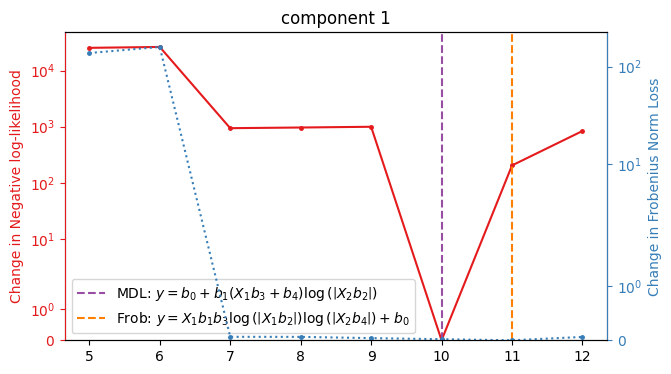

analysing 2 of 2 nonlinear components
fitting y component 1
8 equations below complexity threshold
Best equation: (0.000002 + (7.059982 * (log(abs(((((-0.198523) * X1) * (0.200583 * X1)) + ((-0.217138) * X2)))) + (0.036713 * X1))))
Best frob loss equation: (0.000002 + (7.059982 * (log(abs(((((-0.198523) * X1) * (0.200583 * X1)) + ((-0.217138) * X2)))) + (0.036713 * X1))))


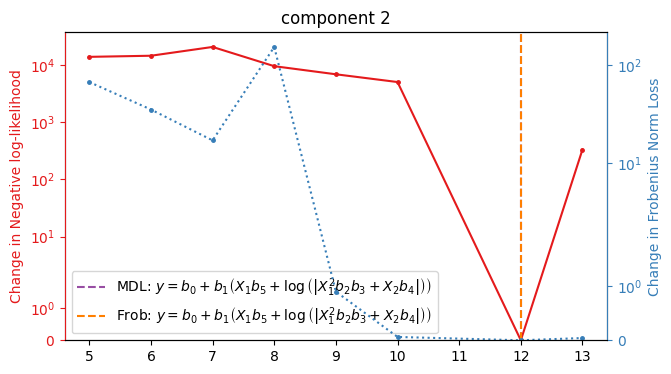

In [182]:
components_to_fit = [0,1]

mdl_coordinates = []
frob_coordinates = []
mse_threshold = 20 # 10
n_components = len(components_to_fit)

both_comp_latex = []
both_comp_eqs = []
both_comp_frobloss = []
both_comp_logL = []
both_comp_DL = []


max_complexity_thresh = 14

for i in range(n_components):

    idx = components_to_fit[i]
    
    print("analysing %d of %d nonlinear components"%(i+1, n_components))
    print("fitting y component %d"%(idx))

    outdir = parent_dir + "component_%d/"%(i + 1)
    # Find what description length (arXiv:2211.11461, Eq. 6) gives
    #data = pd.read_csv(outdir + 'final_population.csv', delimiter=";")

    data = pd.read_csv(outdir + 'pareto.csv', delimiter=";")[:]
 
    #mse_threshold = mse_thresholds[idx]
    loss = np.array(data["mse"])
    #mse_threshold = np.inf

    # mse_mask = (loss < mse_threshold)
    complexity = np.array(data["length"])
    mse_mask = (complexity < max_complexity_thresh)
    print("%d equations below complexity threshold"%(mse_mask.sum()))

    complexity = np.array(data["length"])[mse_mask]

    max_complexity = complexity.max()

    eqs = list(np.array(data['model'])[mse_mask])

    # chop some out to speed up code
    #eqs = eqs

    all_DL = np.ones(len(eqs)) * np.inf
    all_logL = np.ones(len(eqs)) * np.inf
    all_frobloss = np.ones(len(eqs)) * np.inf
    all_latex = [None] * len(eqs)

    for i, eq in tq(enumerate(eqs)):
        c, all_latex[i], all_logL[i], all_DL[i], all_frobloss[i] = compute_DL(eq, idx)

    # set nans to infs
    all_DL[np.isnan(all_DL)] = np.inf
    all_logL[np.isnan(all_logL)] = np.inf
    all_frobloss[np.isnan(all_frobloss)] = np.inf



    # Only changes in DL and logL matter
    #all_DL -= np.amin(all_DL)
    #all_logL -= np.amin(all_logL)

    # unique complexities
    # complexity = np.sort(np.unique(complexity))[1:] # remove comp=1 e.g. constants


    # get best DL model at given complexity
    pareto_DL = []
    pareto_logL = [] 
    pareto_latex = []
    pareto_eqs = []
    pareto_frobloss = []
    comps = []
    for comp in np.unique(complexity):
        if comp > 1:
            mask = (complexity == comp)
            ibest_model_at_complexity = np.argmin(all_DL[mask])
            pareto_DL.append(all_DL[mask][ibest_model_at_complexity])
            pareto_logL.append(all_logL[mask][ibest_model_at_complexity])
            pareto_frobloss.append(all_frobloss[mask][ibest_model_at_complexity])
            pareto_latex.append(np.array(all_latex)[mask][ibest_model_at_complexity])
            pareto_eqs.append(np.array(eqs)[mask][ibest_model_at_complexity])
            comps.append(comp)

    # redfine kept complexities
    complexity = np.array(comps)

    pareto_DL = np.array(pareto_DL)
    pareto_DL -= np.amin(pareto_DL)

    pareto_logL = np.array(pareto_logL)
    pareto_logL -= np.amin(pareto_logL)

    pareto_frobloss = np.array(pareto_frobloss)
    pareto_frobloss -= np.amin(pareto_frobloss)

    # store the latex and eq
    both_comp_latex.append(pareto_latex)
    both_comp_eqs.append(pareto_eqs)
    both_comp_frobloss.append(pareto_frobloss)
    both_comp_DL.append(pareto_DL)
    both_comp_logL.append(pareto_logL)

    # Print the best found equation
    ibest = np.argmin(pareto_DL)
    print('Best equation:', pareto_eqs[ibest])
    mdl_coordinates.append(pareto_eqs[ibest])

    # Print the best frob loss equation
    ibest_frob = np.argmin(pareto_frobloss)
    print('Best frob loss equation:', pareto_eqs[ibest_frob])
    frob_coordinates.append(pareto_eqs[ibest_frob])


    fig, ax1 = plt.subplots(1, 1, figsize=(7,4), sharex=True)
    cm = plt.get_cmap('Set1')
    ax2 = ax1.twinx()
    
    #ax1.plot(complexity, pareto_DL, marker='.', color=cm(0), markersize=5, )
    # ax2.plot(complexity, pareto_logL, marker='.', color=cm(1), markersize=5, ls=':')
    ax1.plot(complexity, pareto_logL, marker='.', color=cm(0), markersize=5, )
    ax2.plot(complexity, pareto_frobloss, marker='.', color=cm(1), markersize=5, ls=':')


    #ax1.set_ylabel('Change in Description Length')
    # ax2.set_ylabel('Change in Negative log-likelihood')
    ax1.set_ylabel('Change in Negative log-likelihood')
    ax2.set_ylabel('Change in Frobenius Norm Loss')
    ax1.yaxis.label.set_color(cm(0))
    ax1.tick_params(axis='y', colors=cm(0))
    ax2.spines['left'].set_color(cm(0))

    ax2.yaxis.label.set_color(cm(1))
    ax2.tick_params(axis='y', colors=cm(1))
    ax2.spines['right'].set_color(cm(1))

    ax1.set_yscale('symlog')
    ax2.set_yscale('symlog')
    ax1.set_ylim(0, None)
    ax2.set_ylim(0, None)

    #ax1.axvline(complexity[pysr_ibest], color=cm(2), ls=':', label=r'Score: $y = %s$'%all_latex[pysr_ibest])
    ax1.axvline(complexity[ibest], color=cm(3), ls='--', label=r'MDL: $y = %s$'%pareto_latex[ibest])
    ax1.axvline(complexity[ibest_frob], color=cm(4), ls='--', label=r'Frob: $y = %s$'%pareto_latex[ibest_frob])

    ax1.legend()
    plt.title("component %d"%(idx + 1))
    plt.show()
    #fig.savefig('function_ranking.png', bbox_inches='tight', facecolor='white')


In [183]:
mdl_coordinates,

(['((-0.912981) + (0.999093 * (log(abs(((-0.083364) * X2))) * (((-1.534599) * X1) + (-0.705927)))))',
  '(0.000002 + (7.059982 * (log(abs(((((-0.198523) * X1) * (0.200583 * X1)) + ((-0.217138) * X2)))) + (0.036713 * X1))))'],)

# post-process SR expressions

In [184]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
# Import postprocessing (SR optimization)
from postprocessing_utils import (
    lossfn_jac_jax,
    get_component,
    get_pruned_expressions,
    get_pruned_expressions_final,
    check_flattening,
    make_check_flattening_fn,
    get_Q_jax, construct_M
)




### demo


In [186]:
all_pars = []
all_linear_pars = []
all_fns = []
all_linear_inds = []
all_param_dicts = []
all_xs = []
all_bs = []

all_expr = []

all_linear_labels = []

for i in range(n_params):
    # lab, expr, prs, _x, _b, eq_fn, oldexpr, nodes = get_component(mdl_coordinates[i], i)

    lab, expr, prs, linear_prs, _x, _b, eq_fn, param_dict, linear_inds = get_component(mdl_coordinates[i], i, X=X, module="jax")
    all_pars.append(prs)
    all_linear_pars.append(linear_prs)
    all_fns.append(eq_fn)
    all_xs.append(_x)
    all_bs.append(_b)
    all_linear_inds.append(linear_inds)
    all_param_dicts.append(param_dict)
    all_expr.append(expr)

    all_linear_labels.append([_b[l] for l in linear_inds])



In [337]:
from scipy.optimize import minimize
import jax.scipy.optimize


np.random.seed(0)

Ainit = (np.random.normal(size=(n_params,n_params))) * (2./n_params**2) # he initialisation

# Ainit = np.random.uniform(size=(n_params,n_params))


# Create loss function
_lossfn = lambda a: lossfn_jac_jax(
    a, all_pars, all_fns, all_linear_pars, all_linear_inds,
    X=X, Fs=Fs, n_params=n_params, delta=0.2, alpha=0.7, smoothl1=False, compare_jacs=False, lambda_flat=1.0
)


res = jax.scipy.optimize.minimize(jax.jit(_lossfn), x0=Ainit.flatten(), 
                                  method="BFGS",
                                  tol=1e-10,
              #options=dict(maxiter=200, disp=True, gtol=1e-3), 
               #jac=True,
                # constraints=constraints,
            #    hess=lambda x: np.zeros_like(x)
               )

Aopt = (res.x.reshape((n_params,n_params)))
Aopt = get_Q_jax(Aopt)


In [338]:
Aopt

Array([[ 0.9746845 , -0.22358559],
       [ 0.22358559,  0.9746843 ]], dtype=float32)

In [339]:
Aopt @ Aopt.T

Array([[1.0000004e+00, 3.4999239e-08],
       [3.4999239e-08, 1.0000000e+00]], dtype=float32)

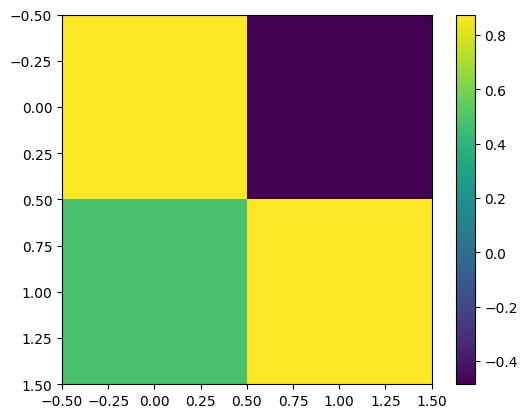

In [340]:
plt.imshow(get_Q_jax(Ainit))
plt.colorbar()

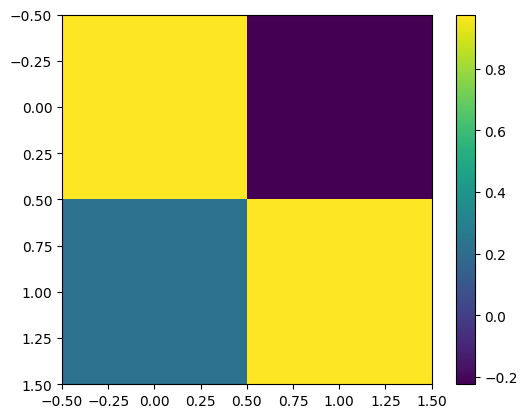

In [341]:
plt.imshow((Aopt))
plt.colorbar()

In [342]:
_lossfn = lambda a: lossfn_jac_jax(a, all_pars, all_fns, all_linear_pars, all_linear_inds, parts=True, X=X, Fs=Fs, n_params=n_params)

_lossfn(Aopt), _lossfn(np.eye(n_params))

((Array(15.80951, dtype=float32),
  Array(0.07661724, dtype=float32),
  Array(43.044376, dtype=float32)),
 (Array(13.912144, dtype=float32),
  Array(0.08835948, dtype=float32),
  Array(47.207973, dtype=float32)))

In [343]:
all_linear_pars, mdl_coordinates

([array([-0.912981,  0.999093, -1.534599, -0.705927]),
  array([2.000000e-06, 7.059982e+00, 3.671300e-02])],
 ['((-0.912981) + (0.999093 * (log(abs(((-0.083364) * X2))) * (((-1.534599) * X1) + (-0.705927)))))',
  '(0.000002 + (7.059982 * (log(abs(((((-0.198523) * X1) * (0.200583 * X1)) + ((-0.217138) * X2)))) + (0.036713 * X1))))'])

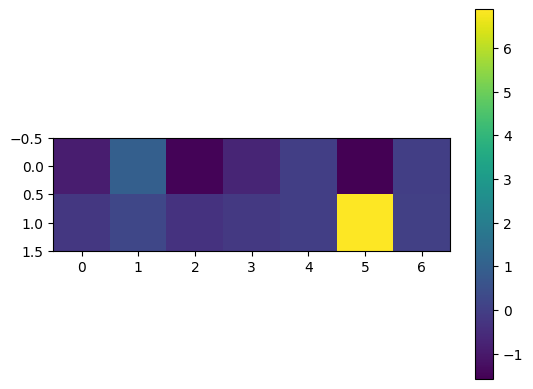

In [344]:
plt.imshow((Aopt @ construct_M(all_linear_pars, n_params=n_params)))
plt.colorbar()

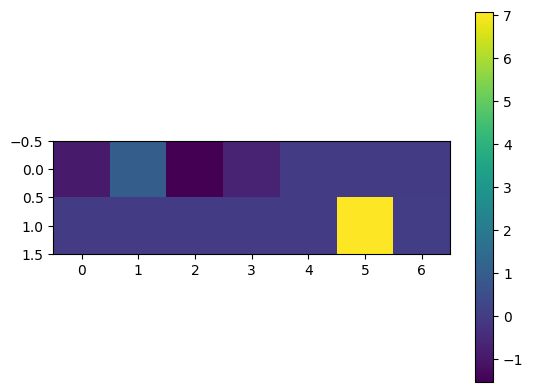

In [345]:
plt.imshow(construct_M(all_linear_pars, n_params=n_params))
plt.colorbar()

In [346]:
get_pruned_expressions(np.eye(n_params), 
                      all_param_dicts,
                       all_pars, all_linear_pars, all_expr, all_linear_labels, remove_floats=False, threshold=1e-20, n_params=n_params
                       )


(['-(1.533*X1 + 0.705)*(log(Abs(X2)) - 2.485) - 0.913',
  '0.259*X1 + 7.06*log(Abs(0.04*X1**2 + 0.217*X2))'],
 [[1.533, 0.705, 2.485, 0.913], [0.259, 7.06, 0.04, 0.217]])

In [347]:
sr_exprs_vanilla, _ = get_pruned_expressions_final(np.eye(n_params), 
                      all_param_dicts,
                       all_pars, all_linear_pars, 
                       all_expr, all_linear_labels, 
                       remove_floats=False, threshold=0.05, n_params=n_params, X=X, Fs=Fs
                       )

Looking at component 0
  delta: 0.000000
  zeroed component -> skip!
  delta: 380033.656250
  delta: 0.030689
Looking at component 1
  delta: 0.000000
  zeroed component -> skip!
  delta: -0.049588


In [348]:
sr_exprs_vanilla

['X1*(3.809 - 1.533*log(Abs(X2)))', '7.06*log(Abs(0.04*X1**2 + 0.217*X2))']

In [349]:
sr_exprs_vanilla

['X1*(3.809 - 1.533*log(Abs(X2)))', '7.06*log(Abs(0.04*X1**2 + 0.217*X2))']

In [350]:
fit_exprs0, _ = get_pruned_expressions(Aopt, all_param_dicts,
            all_pars, all_linear_pars, all_expr, all_linear_labels, remove_floats=False, threshold=0.1, decimal=3, n_params=n_params)

In [351]:
fit_exprs0

['-(1.457*X1 + 0.67)*(log(Abs(X2)) - 2.485) - 1.579*log(Abs(0.04*X1**2 + 0.217*X2)) - 0.89',
 '-(0.077*X1 + 0.035)*(log(Abs(X2)) - 2.485) + 6.881*log(Abs(0.04*X1**2 + 0.217*X2)) - 0.204']

In [352]:
fit_exprs, _ = get_pruned_expressions_final(Aopt, all_param_dicts,
            all_pars, all_linear_pars, all_expr, all_linear_labels,
             remove_floats=False, threshold=1.0, n_params=n_params, X=X, Fs=Fs, decimal=3, update=False, verbose=True)

Looking at component 0
  delta: 0.000000
  delta: 3248.898682
  delta: 5192501.500000
  delta: -0.023705
Looking at component 1
  delta: 0.000000
  delta: 961842112.000000
  delta: -0.017005


In [353]:
fit_exprs

['-X1*(1.457*log(Abs(X2)) - 3.619) - 1.579*log(Abs(0.04*X1**2 + 0.217*X2))',
 '-X1*(0.077*log(Abs(X2)) - 0.19) + 6.881*log(Abs(0.04*X1**2 + 0.217*X2))']

In [354]:

check_flats = lambda c: check_flattening(c, X=X, Fs=Fs)

In [355]:
n_d = 1
mdl_flats, mdl_J = check_flats(mdl_coordinates)
frob_flats, frob_J = check_flats(frob_coordinates)

In [356]:
from copy import deepcopy
fit_exprs2 = deepcopy(fit_exprs)

# substitute in mdl coordinates for zero components
# fit_exprs2[1] ="0.0" 
# fit_exprs2[0] = "0.0"

fit_exprs2, mdl_coordinates

(['-X1*(1.457*log(Abs(X2)) - 3.619) - 1.579*log(Abs(0.04*X1**2 + 0.217*X2))',
  '-X1*(0.077*log(Abs(X2)) - 0.19) + 6.881*log(Abs(0.04*X1**2 + 0.217*X2))'],
 ['((-0.912981) + (0.999093 * (log(abs(((-0.083364) * X2))) * (((-1.534599) * X1) + (-0.705927)))))',
  '(0.000002 + (7.059982 * (log(abs(((((-0.198523) * X1) * (0.200583 * X1)) + ((-0.217138) * X2)))) + (0.036713 * X1))))'])

In [357]:
n_d = 1
fit_expr_flats0, _ = check_flats(fit_exprs0)
sr_expr_flats, _ = check_flats(sr_exprs_vanilla)

fit_expr_flats, _ = check_flattening(fit_exprs, X=X, Fs=Fs)


In [358]:
sr_exprs_vanilla

['X1*(3.809 - 1.533*log(Abs(X2)))', '7.06*log(Abs(0.04*X1**2 + 0.217*X2))']

In [359]:
true_coords = ["X1**2 - X2", "X1"]
true_flats,_ = check_flattening(true_coords, X=X, Fs=Fs)
jax.vmap(norm)(true_flats - jnp.eye(n_params)).mean()

Array(296.42938, dtype=float32)

In [360]:
jax.vmap(norm)(sr_expr_flats - jnp.eye(n_params)).mean()

Array(1.1616108, dtype=float32)

In [361]:
jax.vmap(norm)(fit_expr_flats0 - jnp.eye(n_params)).mean()

Array(1.4121187, dtype=float32)

In [362]:
jax.vmap(norm)(fit_expr_flats - jnp.eye(n_params)).mean()

Array(1.3138353, dtype=float32)

In [363]:
jax.vmap(norm)(mdl_flats - jnp.eye(n_params)).mean()

Array(1.2214235, dtype=float32)

In [364]:
jax.vmap(norm)(sr_expr_flats - jnp.eye(n_params)).mean()

Array(1.1616108, dtype=float32)

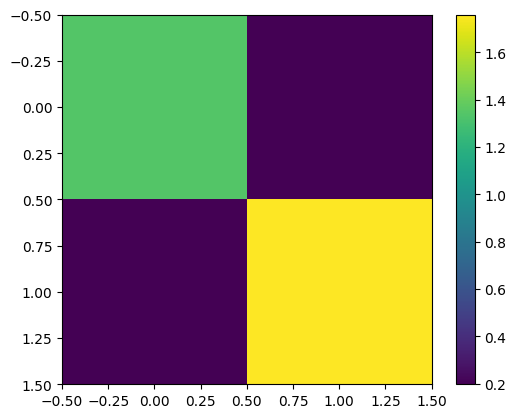

In [365]:
plt.imshow(fit_expr_flats.mean(0))
plt.colorbar()

In [366]:
mdl_flats = jax.vmap(flatten_with_numerical_jacobian)(mdl_J, Fs)
frob_flats = jax.vmap(flatten_with_numerical_jacobian)(frob_J, Fs)

In [367]:
mdl_flats.mean(0), frob_flats.mean(0)

(Array([[ 1.2349093 , -0.04696474],
        [-0.04696474,  1.6972264 ]], dtype=float32),
 Array([[ 1.2699658 , -0.17251062],
        [-0.17251062,  1.6977473 ]], dtype=float32))

In [368]:
#@title fisher code
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

def plot_fisher_ellipse(fisher_matrix, mean=None, ax=None, color='blue', 
                        alpha=1.0, linestyle='-',
                       label=""):
    """
    Plots a Fisher information matrix ellipse.

    Parameters:
        fisher_matrix (numpy.ndarray): Fisher information matrix.
        mean (numpy.ndarray, optional): Mean vector. Defaults to None, in which case the ellipse will be centered at (0, 0).
        ax (matplotlib.axes.Axes, optional): Axes to plot on. If not provided, a new figure will be created.
        color (str, optional): Color of the ellipse. Defaults to 'blue'.
        alpha (float, optional): Transparency of the ellipse. Defaults to 0.5.
        linestyle (str, optional): Linestyle of the ellipse. Defaults to '-'.

    Returns:
        matplotlib.axes.Axes: Axes object with the ellipse plotted.
    """
    if ax is None:
        _, ax = plt.subplots()

    # Invert the Fisher information matrix to get the covariance matrix
    covariance_matrix = np.linalg.inv(fisher_matrix)

    # Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
    order = eigenvalues.argsort()[::-1]
    eigenvalues = eigenvalues[order]
    eigenvectors = eigenvectors[:, order]

    # Calculate ellipse angle
    angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

    # If mean is provided, set the center of the ellipse accordingly
    if mean is not None:
        center = mean
    else:
        center = np.zeros_like(covariance_matrix.shape[0])

    # Create ellipse for 1-sigma contour
    ellipse = Ellipse(xy=center,
                      width=2 * np.sqrt(eigenvalues[0]),
                      height=2 * np.sqrt(eigenvalues[1]),
                      angle=angle,
                      edgecolor=color,
                      linestyle=linestyle,
                      facecolor='none',
                      alpha=alpha,
                      label=label)

    # Create ellipse for 2-sigma contour
    ellipse2 = Ellipse(xy=center,
                       width=2 * 2 * np.sqrt(eigenvalues[0]),
                       height=2 * 2 * np.sqrt(eigenvalues[1]),
                       angle=angle,
                       edgecolor=color,
                       linestyle=linestyle,
                       facecolor='none',
                       alpha=alpha)

    ax.add_patch(ellipse)
    ax.add_patch(ellipse2)
    #ax.set_aspect('equal', 'box')
    ax.autoscale()
    return ax

In [369]:
#nn_flats = jax.vmap(jax.vmap(flatten_with_numerical_jacobian))(dys, ensemble_Fs).mean(0)

nn_flats = jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)

In [370]:
Fs, dy

(array([[[23.944645  ,  0.50941104],
         [ 0.50941104, 15.466144  ]],
 
        [[43.348534  , -0.7520413 ],
         [-0.7520413 , 27.384037  ]],
 
        [[ 1.4054774 , -0.17401278],
         [-0.17401278,  2.9433472 ]],
 
        ...,
 
        [[41.40395   , -1.5206364 ],
         [-1.5206364 , 25.290398  ]],
 
        [[ 2.1676502 , -0.11374354],
         [-0.11374354,  2.6063712 ]],
 
        [[ 3.9034941 ,  0.04509666],
         [ 0.04509666,  3.682652  ]]], dtype=float32),
 array([[[-2.66882   ,  4.0239186 ],
         [-2.7300181 , -2.271116  ]],
 
        [[-4.6359186 ,  4.182041  ],
         [-2.5894105 , -3.8589952 ]],
 
        [[-1.1802995 , -0.30003554],
         [ 0.566054  , -1.570506  ]],
 
        ...,
 
        [[-3.3362734 , -4.93317   ],
         [ 3.7727551 , -2.0303805 ]],
 
        [[-1.2679123 , -0.4064194 ],
         [ 0.59347206, -1.491566  ]],
 
        [[-1.530852  ,  0.9745133 ],
         [-1.0767651 , -1.5338979 ]]], dtype=float32))

In [371]:
nn_flats = jax.vmap(flatten_with_numerical_jacobian)(dy, Fs)
nn_flats.mean(0)

Array([[ 1.1239675 , -0.05148863],
       [-0.05148863,  1.2541645 ]], dtype=float32)

In [372]:
from preprocessing_utils import get_eigenvalues as get_evalues
evalues_nn = jax.vmap(get_evalues)(nn_flats)
evalues_mdl = jax.vmap(get_evalues)(mdl_flats)
evalues_frob = jax.vmap(get_evalues)(frob_flats)

evalues_fitexpr = jax.vmap(get_evalues)(sr_expr_flats)

In [373]:
evalues_fitexpr

Array([[1.0628974 , 1.619941  ],
       [0.29935062, 1.9254748 ],
       [0.61543244, 1.9473671 ],
       ...,
       [0.4331277 , 3.957253  ],
       [0.80163646, 1.5005695 ],
       [1.1352955 , 1.4542499 ]], dtype=float32)

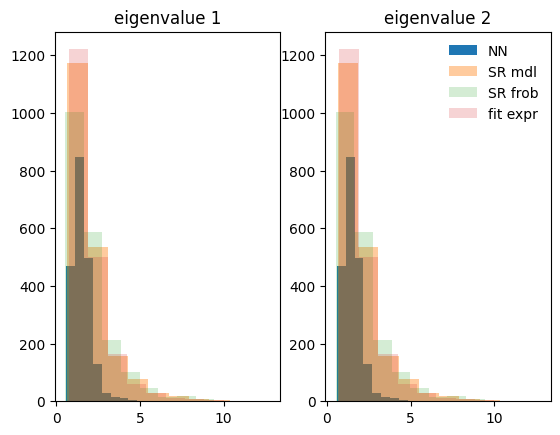

In [374]:
plt.subplot(121)
plt.title("eigenvalue 1")

plt.hist(evalues_nn[:, 3], label="NN")
plt.hist(evalues_mdl[:, 3], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 3], alpha=0.2, label="SR frob")
plt.hist(evalues_fitexpr[:, 3], alpha=0.2, label="fit expr")


plt.subplot(122)
plt.title("eigenvalue 2")
plt.hist(evalues_nn[:, 1], label="NN")
plt.hist(evalues_mdl[:, 1], alpha=0.4, label="SR mdl")
plt.hist(evalues_frob[:, 1], alpha=0.2, label="SR frob")
plt.hist(evalues_fitexpr[:, 1], alpha=0.2, label="fit expr")


plt.legend(framealpha=0.0)

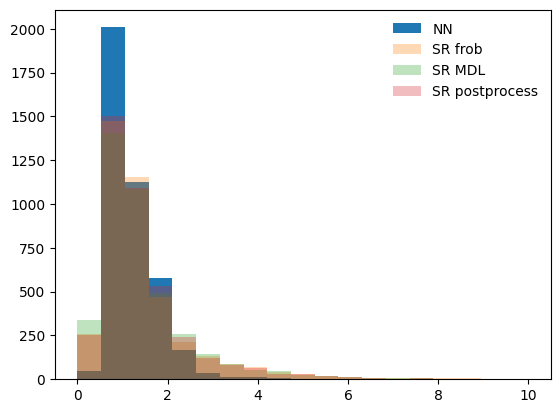

In [375]:
bins = np.linspace(0, 10, 20)
plt.hist(np.array(evalues_nn).flatten(), bins=bins, label='NN')
plt.hist(np.array(evalues_frob).flatten(), bins=bins, alpha=0.3, label='SR frob')
plt.hist(np.array(evalues_mdl).flatten(), bins=bins, alpha=0.3, label='SR MDL')
plt.hist(np.array(evalues_fitexpr).flatten(), bins=bins, alpha=0.3, label='SR postprocess')
plt.legend(framealpha=0.0)

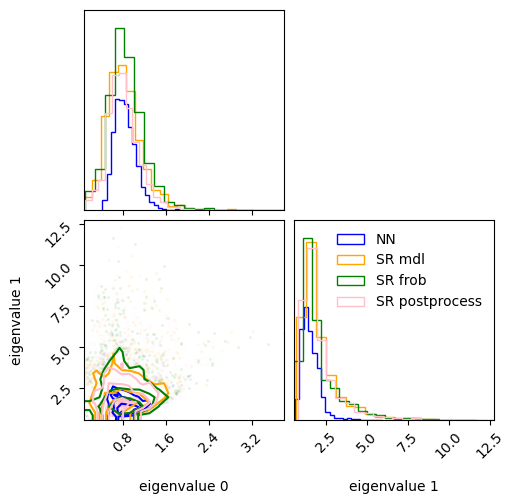

In [376]:
import corner

cols = ['eigenvalue %d'%(i) for i in range(n_params)]

figure = corner.corner(np.array(evalues_nn), color="blue", labels=cols, hist_kwargs=dict(label="NN"))
figure = corner.corner(np.array(evalues_mdl), color="orange", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR mdl"))
figure = corner.corner(np.array(evalues_frob), color="green", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR frob"))
figure = corner.corner(np.array(evalues_fitexpr), color="pink", fig=figure, labels=cols, alpha=0.2, hist_kwargs=dict(label="SR postprocess"))


plt.legend(framealpha=0.0)


In [377]:
nn_flats

Array([[[ 0.79996425,  0.3566296 ],
        [ 0.35662964,  1.7509826 ]],

       [[ 1.0235205 ,  0.44320014],
        [ 0.44320017,  1.5974084 ]],

       [[ 1.0014005 ,  0.24696372],
        [ 0.24696374,  1.0624241 ]],

       ...,

       [[ 0.78731245, -0.12162963],
        [-0.12162966,  2.0780795 ]],

       [[ 1.2181923 ,  0.10105762],
        [ 0.1010576 ,  1.0260085 ]],

       [[ 1.1526586 , -0.01531981],
        [-0.01531979,  1.0804799 ]]], dtype=float32)

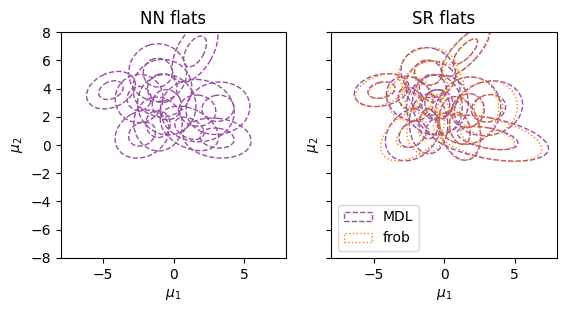

In [379]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 2, sharey=True) 


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")

ax.set_box_aspect(1)


plt.legend()

#plt.tight_layout()

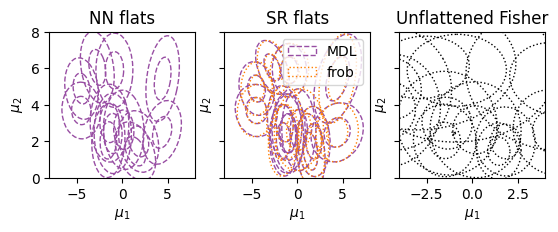

In [383]:
# plot a smattering of fishers

randidx = np.random.choice(halfx, size=(12), replace=False)


_, axs = plt.subplots(1, 3, sharey=True)


ax = axs[0]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(nn_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(nn_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))



ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("NN flats")
ax.set_box_aspect(1)
ax = axs[1]

mdl_evalues = []

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(mdl_flats[r], mean=X[r], ax=ax, label=labels[0], linestyle='--', color=cm(3))


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r],ax=ax, mean=X[r], color=cm(3), linestyle='--')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
        
        plot_fisher_ellipse(frob_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(4))

ax.legend()

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8, 8)
ax.set_ylim(-8, 8)
ax.set_title("SR flats")


ax.set_box_aspect(1)




ax = axs[2]

for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r]*50,ax=ax, mean=X[r], color='k', linestyle=':')

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "frob"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r] / 10., mean=X[r], ax=ax, label=labels[1], linestyle=':', color='k')
        #plot_fisher_ellipse(score_flats[r], mean=X[r], ax=ax, label=labels[1], linestyle=':', color=cm(2))




ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-4, 4)
ax.set_ylim(0, 8)
ax.set_title("Unflattened Fisher")
ax.set_box_aspect(1)



#plt.tight_layout()

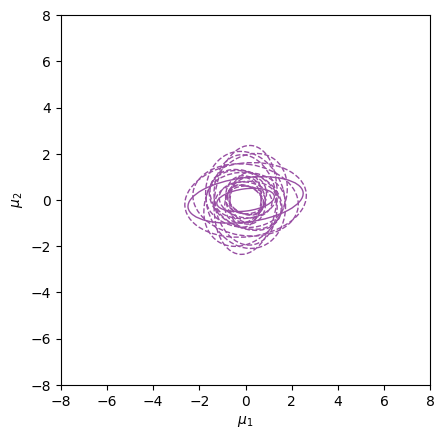

In [386]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-8,8)
ax.set_ylim(-8, 8)
ax.set_box_aspect(1)
#plt.legend()

In [387]:
Fs * 50

array([[[1197.2323   ,   25.470552 ],
        [  25.470552 ,  773.3072   ]],

       [[2167.4268   ,  -37.602062 ],
        [ -37.602062 , 1369.2019   ]],

       [[  70.27387  ,   -8.700639 ],
        [  -8.700639 ,  147.16736  ]],

       ...,

       [[2070.1975   ,  -76.03182  ],
        [ -76.03182  , 1264.5199   ]],

       [[ 108.38251  ,   -5.6871767],
        [  -5.6871767,  130.31856  ]],

       [[ 195.17471  ,    2.254833 ],
        [   2.254833 ,  184.1326   ]]], dtype=float32)

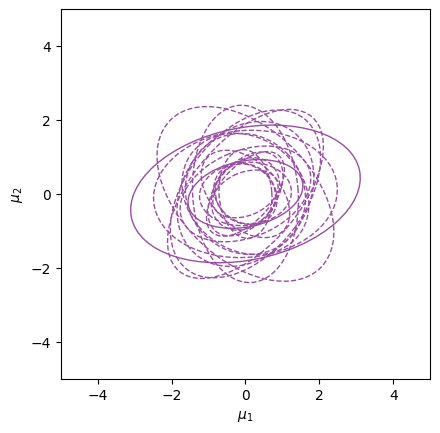

In [388]:
# plot a smattering of fishers

randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(frob_flats[r], mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(mdl_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()

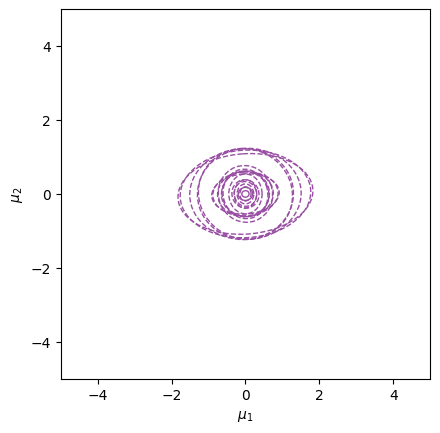

In [389]:
# plot a smattering of fishers

#randidx = np.random.choice(1000, size=(10), replace=False)


for i,r in enumerate(randidx):
    if i == 0:
        ax = plot_fisher_ellipse(Fs[r] * 50, mean=np.array([0, 0]), color=cm(3))

    else: 
        if i == len(randidx) - 1:
            labels = ["MDL", "score"]
        else:
            labels = [None, None]
            
        plot_fisher_ellipse(Fs[r], mean=np.array([0, 0]), ax=ax, label=labels[0], linestyle='--', color=cm(3))
        #plot_fisher_ellipse(score_flats[r], mean=np.array([0, 0]), ax=ax, label=labels[1], linestyle=':', color=cm(2))

ax.set_ylabel(r"$\mu_2$")
ax.set_xlabel(r"$\mu_1$")
ax.set_xlim(-5,5)
ax.set_ylim(-5, 5)
ax.set_box_aspect(1)
#plt.legend()

# compare against Geodesic normal coordinates

In [390]:
# insert Deaglan's and Ben's coordinates

ad_hoc_coordinates = ['X1 * (1. / sqrt(X2)) * sqrt(50.)', 'log(X2) * sqrt(50.)']

# now geodesic normal coordinates

theta_star = np.array([0.0, 1.0])

def get_geo_coordinates(X, theta_star=theta_star):
    x1, x2 = X

    mu = x1
    sg = x2

    sg_star = (theta_star[1])
    mu_star = theta_star[0]
    
    beta = jnp.arcsinh( 
        ((1./(2. * sg_star * sg)) ) \
                * ((0.5 * (mu - mu_star)**2 + (sg - sg_star)**2)
                       * (0.5 * (mu - mu_star)**2 + (sg + sg_star)**2))**0.5
    )

    eta = jnp.where((mu == mu_star), jnp.sqrt(2.0) * beta * jnp.sign(0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2),
                   0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2 \
                      * jnp.sign(0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2)
    ) # \eta

    # y1 = 0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2 \
    #                  * jnp.sign(0.5 * (mu - mu_star)**2 + sg**2 - sg_star**2)
    
    xi = jnp.where((mu == mu_star), 0.0, 
                   sg_star * (mu - mu_star) * jnp.sqrt(2.0) * jnp.sign(mu - mu_star)
    ) # \xi

    # y2 = sg_star * (mu - mu_star) * jnp.sqrt(2.0) * jnp.sign(mu - mu_star)

    return jnp.array([xi, eta]) #/ jnp.sqrt(50.)



def get_beta(X, theta_star=theta_star, return_beta=False):

    x1,x2 = X
    mu = x1
    sg = x2

    sg_star = (theta_star[1])
    mu_star = theta_star[0]
    
    beta = jnp.arcsinh( 
        ((1./(2. * sg_star * sg)) ) \
                * ((0.5 * (mu - mu_star)**2 + (sg - sg_star)**2)
                       * (0.5 * (mu - mu_star)**2 + (sg + sg_star)**2))**0.5

    )
    if return_beta:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0, beta
    else:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0  #(1./3.) * beta**2


geo_coordinates = ['0.5 * (X1 - 0.)^2 + X2 - 1.0', '1.0 * (X1 - 0.) * sqrt(2.)']


# geo_coordinates = [ '1.0 * (X1 - 0.) * sqrt(2.)', '0.5 * (X1 - 0.)^2 + X2 - 1.']


In [391]:
sigma_star = 1.0
mu_star = 0.0

u_star = mu_star / sigma_star
v_star = jnp.sqrt(2)

def x_to_sinhbeta(x):
    sinh_beta = jnp.sqrt(
            (0.5 * (x[0] - mu_star)**2 + (x[1] - sigma_star)**2) *
            (0.5 * (x[0] - mu_star)**2 + (x[1] + sigma_star)**2)
        ) / x[1] / sigma_star / 2
    return sinh_beta


def xp_to_beta(xp):
    xi, eta = xp
    beta = jnp.sqrt(xi**2 + eta**2) / v_star
    return beta


def get_beta(X, return_beta=False):    
    xp = x_to_xprime(X)
    beta = xp_to_beta(xp)

    if return_beta:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0, beta
    else:
        return ((jnp.sinh(beta)**2.0) / beta**2.0) - 1.0  #(1./3.) * beta**2
    

def x_to_xprime(x):
    sinh_beta = x_to_sinhbeta(x)
    beta = jnp.arcsinh(sinh_beta)
    
    xi = jnp.where(jnp.abs(beta) > 1e-4,
                   beta * (x[0] - mu_star) / x[1] / sinh_beta,
                    0,
    )
    eta = jnp.where(jnp.abs(beta) > 1e-4,
                xi * (0.5 * (x[0] - mu_star)**2 + x[1] ** 2 - sigma_star**2) / 
                (sigma_star * (x[0] - mu_star) * jnp.sqrt(2)),
                0,
    )
    xprime = jnp.array([xi, eta])
    return xprime


def xprime_to_x(xp):

    beta = xp_to_beta(xp)
    xi, eta = xp
    u = jnp.where(beta == 0,
                   u_star,
                    (u_star + 
                        v_star * xi * jnp.sinh(beta) / 
                        (beta * v_star * jnp.cosh(beta) - eta * jnp.sinh(beta))
                    )
    )

    v = jnp.where(beta == 0,
                    v_star,
                    v_star * (
                        beta * v_star / 
                        (beta * v_star * jnp.cosh(beta) - eta * jnp.sinh(beta))
                    )
    )

    x = jnp.array([u * sigma_star, v * sigma_star / jnp.sqrt(2)])

    return x

def metric_fn(x):
    g = jnp.zeros((2, 2))
    g = g.at[0, 0].set(1 / x[1] ** 2)
    g = g.at[1, 1].set(2 / x[1] ** 2)
    return g


def transformed_metric(xp):
    x = xprime_to_x(xp)
    J = jax.jacfwd(x_to_xprime)(x)
    Jinv = jnp.linalg.inv(J)
    g = metric_fn(x)
    return Jinv.T @ g @ Jinv


def predicted_metric(xp):
    beta = xp_to_beta(xp)
    if beta == 0:
        return jnp.eye(2)
    xi, eta = xp
    g = jnp.zeros((2, 2))
    g = g.at[0, 0].set(eta**2 * jnp.sinh(beta)**2 + xi**2 * beta**2)
    g = g.at[0, 1].set(xi * eta * (beta ** 2 - jnp.sinh(beta)**2))
    g = g.at[1, 0].set(g[0, 1])
    g = g.at[1, 1].set(eta**2 * beta **2 + xi**2 * jnp.sinh(beta)**2)
    g = g / 2 / beta ** 4
    return g

In [392]:
# create some true fishers everywhere


def true_fisher(X):
    n_d = 50
    mu = X[0]
    sig = (X[1])
    return n_d * jnp.array([[1./sig**2, 0.0],[0.0, 2. / sig**2]])


# def true_fisher(X):
#     n_d = 50
#     mu = X[0]
#     sig = jnp.sqrt(X[1])
#     return n_d * jnp.array([[1./sig**2, 0.0],[0.0, 1. / sig**4]])


true_fs = jax.vmap(true_fisher)(X)

In [ ]:
flatten

In [424]:
# FUNCTIONS FOR CHECKING THE FLATNESS OF NEURAL AND NUMERICAL FNs

n_params = 2

frobenius_norm_loss = lambda q: norm((q - jnp.eye(n_params))) #+ norm((jnp.linalg.inv(q) - jnp.eye(n_params)))


def check_neural_flattening(Js, Fs, get_frob=True):
    flats = jax.vmap(flatten_with_numerical_jacobian)(Js, Fs)

    if get_frob:
        return flats, jax.vmap(frobenius_norm_loss)(flats).mean()
    else:
        return flats


def flatten_with_fn(X, F, myfunc=get_geo_coordinates):    
    J_eta = jax.jacobian(myfunc)(X)
    Jeta_inv = jnp.linalg.pinv(J_eta)

    Q = Jeta_inv.T @ F @ Jeta_inv # REVERSED THIS FOR ANALYTIC CONVENTION

    return Q

def check_numerical_fn_flattening(Xs, Fs, get_frob=True, myfunc=get_geo_coordinates):

    flatfn = lambda x,f: flatten_with_fn(x,f, myfunc=myfunc)
    flats = jax.vmap(flatfn)(Xs, Fs)

    if get_frob:
        return flats, jax.vmap(frobenius_norm_loss)(flats)
    else:
        return flats


def get_evalues(M):
    eigenvalues, eigenvectors = jnp.linalg.eigh(M)
    
    return eigenvalues[eigenvalues.argsort()]


In [425]:
nn_flats, nn_score = check_neural_flattening(dy, Fs)

geo2_flats, geo2_score = check_numerical_fn_flattening(X, Fs)

In [426]:
frb = jax.vmap(frobenius_norm_loss)

mdl_score = frb(check_flats(mdl_coordinates)[0]).mean()

frob_score = frb(check_flats(frob_coordinates)[0]).mean()

adhoc_score = frb(check_flats(ad_hoc_coordinates)[0]).mean()

nn_score = frb(nn_flats).mean()

geo_score = frb(check_flats(geo_coordinates)[0]).mean()

beta_geo_score = jax.vmap(get_beta)(X).mean()


geo2_flats, geo2_losses = check_numerical_fn_flattening(X, Fs / 50., myfunc=x_to_xprime)
geo2_score = geo2_losses.mean()


In [427]:
print("\nchecking against neural fishers\n---")
print("neural network flattening score:", nn_score)
print("MDL SR flattening score:", mdl_score)
print("Frob SR flattening score:", frob_score)
print('ad-hoc flattening score:', adhoc_score)
# print('geo flattening score:', geo_score)
print('numerical geo flattening score:', geo2_score)
print('frob norm geo flattening score:', beta_geo_score)



checking against neural fishers
---
neural network flattening score: 0.6361504
MDL SR flattening score: 1.2214235
Frob SR flattening score: 1.2126126
ad-hoc flattening score: 1.5338609
numerical geo flattening score: 1.588646
frob norm geo flattening score: 1.6277703


In [430]:

mdl_score = frb(check_flattening(mdl_coordinates, X, Fs=true_fs)[0]).mean()
frob_score = frb(check_flattening(frob_coordinates, X, Fs=true_fs)[0]).mean()
adhoc_score = frb(check_flattening(ad_hoc_coordinates, X, Fs=true_fs)[0]).mean()

geo_score = frb(check_flattening(geo_coordinates, X, Fs=true_fs)[0]).mean()


# check neural network and numerical geodesic normal coord solution as well
nn_score = check_neural_flattening(dy, true_fs)[1]

geo2_flats, geo2_losses = check_numerical_fn_flattening(X, true_fs / 50, myfunc=x_to_xprime)
geo2_score = geo2_losses.mean()

print("\nchecking against true fishers\n---")
print("neural network flattening score:", nn_score)
print("MDL SR flattening score:", mdl_score)
print("Frob SR flattening score:", frob_score)
print('ad-hoc flattening score:', adhoc_score)
# print('geo flattening score:', geo_score)
print('numerical geo flattening score:', geo2_score)
print('frob norm geo flattening score:', beta_geo_score)


checking against true fishers
---
neural network flattening score: 1.6465075
MDL SR flattening score: 1.9847586
Frob SR flattening score: 1.8076593
ad-hoc flattening score: 2.0426126
numerical geo flattening score: 1.6277702
frob norm geo flattening score: 1.6277703


In [431]:
geo2_losses

Array([0.45442045, 0.1977671 , 1.8440758 , ..., 4.2443476 , 1.6736566 ,
       0.9236982 ], dtype=float32)

In [432]:
mask_fid = ((np.abs(X[:, 0]) < 0.5) & (X[:, 1] < 2.0) & (X[:, 1] > 0.5))

dff = X - jnp.array([mu_star, sigma_star])

mask_fid = (np.abs(dff)[:, 0] < 0.2) & (np.abs(dff)[:, 1] < 0.2)

print(mask_fid.sum())


# check neural network and numerical geodesic normal coord solution as well
_, nn_score_fid = check_neural_flattening(dy[mask_fid], Fs[mask_fid])
_, geo2_score_fid = check_numerical_fn_flattening(X[mask_fid], Fs[mask_fid] / 50, myfunc=x_to_xprime)

beta_geo_score = jax.vmap(get_beta)(X[mask_fid]).mean()


print("\nchecking against neural fishers\n---")

print("neural network flattening score near fiducial:", nn_score_fid)
print('numerical geo flattening score near fiducial:', geo2_score_fid.mean())
print('frob norm geo flattening score near fiducial:', beta_geo_score)

3

checking against neural fishers
---
neural network flattening score near fiducial: 0.7435725
numerical geo flattening score near fiducial: 0.8433336
frob norm geo flattening score near fiducial: 0.0041641397


In [433]:
betas.shape, geo2_losses.shape

Text(0, 0.5, 'geo coordinate losses')

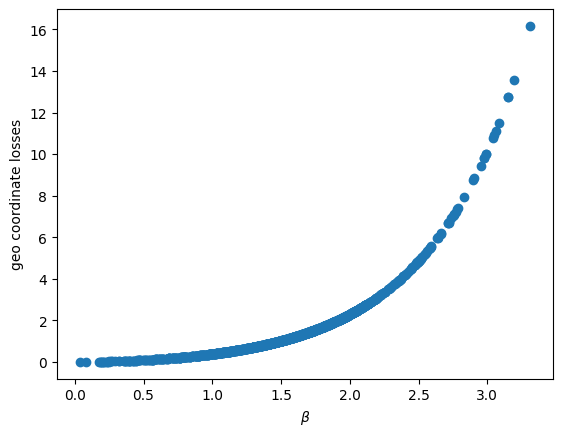

In [434]:
# check losses as fn of beta

gb = lambda x: get_beta(x, return_beta=True)
_, betas = jax.vmap(gb)(X)
# plt.hist(betas)

plt.scatter(betas, geo2_losses)
plt.xlabel(r'$\beta$')
plt.ylabel(r'geo coordinate losses')

In [435]:
# check neural network and numerical geodesic normal coord solution as well
_, nn_score_fid = check_neural_flattening(dy[mask_fid], true_fs[mask_fid])
_, geo2_score_fid = check_numerical_fn_flattening(X[mask_fid], true_fs[mask_fid] / 50)

print("\nchecking against true fishers\n---")
print("neural network flattening score near fiducial:", nn_score_fid)
print('numerical geo flattening score near fiducial:', geo2_score_fid.mean())


checking against true fishers
---
neural network flattening score near fiducial: 4.401703
numerical geo flattening score near fiducial: 0.5569924


In [441]:
betas.shape, frob_losses.shape


checking against true fishers
---
neural network flattening score: 1.6465075
MDL SR flattening score: 1.9847586
Frob SR flattening score: 1.8076593
ad-hoc flattening score: 2.0426126
numerical geo flattening score: 1.6277702
frob norm geo flattening score: 0.0041641397


ValueError: x and y must be the same size

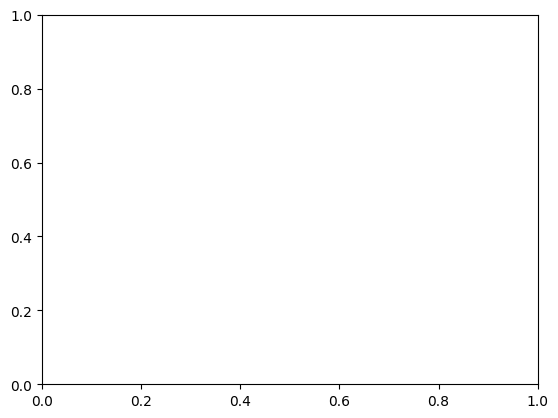

In [ ]:

mdl_losses, _ = check_flattening(mdl_coordinates, X, Fs=true_fs)
mdl_losses = frb(mdl_losses)
mdl_score = mdl_losses.mean()

frob_losses, _ = check_flattening(frob_coordinates, X, Fs=true_fs)
frob_losses = frb(frob_losses)
frob_score = frob_losses()

adhoc_losses, _ = check_flattening(ad_hoc_coordinates, X, Fs=true_fs)
adhoc_losses = frb(adhoc_losses)
adhoc_score = adhoc_losses.mean()

geo_score = frb(check_flattening(geo_coordinates, X, Fs=true_fs)[0]).mean()


# check neural network and numerical geodesic normal coord solution as well
nn_score = check_neural_flattening(dy, true_fs)[1]

geo2_flats, geo2_losses = check_numerical_fn_flattening(X, true_fs / 50, myfunc=x_to_xprime)
geo2_score = geo2_losses.mean()

print("\nchecking against true fishers\n---")
print("neural network flattening score:", nn_score)
print("MDL SR flattening score:", mdl_score)
print("Frob SR flattening score:", frob_score)
print('ad-hoc flattening score:', adhoc_score)
# print('geo flattening score:', geo_score)
print('numerical geo flattening score:', geo2_score)
print('frob norm geo flattening score:', beta_geo_score)


# compare beta vs losses for each type of coord

plt.scatter(betas, mdl_losses, label='MDL SR coordinates')
plt.scatter(betas, frob_losses, label='Frob loss SR coordinates')


plt.scatter(betas, adhoc_losses, label='ad-hoc coordinates')

plt.scatter(betas, geo2_losses, c='k', label='geodesic normal coordinates', s=3)

plt.yscale('log')
plt.ylabel(r'$\mathcal{L} = ||g - I||_\mathcal{F}$')
plt.xlabel(r'$\beta$')
plt.legend(framealpha=0.0)
plt.title('flattening ANALYTIC F')